In [1]:
 
import numpy as np
import matplotlib
from neo.io import AxonIO
#import seaborn as sns
import matplotlib.pyplot as plt
# import the data
#flydir = '/Volumes/hm_data/MN optogenetic activation/b1/1218 fly 3/'
from scipy import stats

In [172]:
flydir = '/home/alysha/media/imager/FlyDataD/untitled folder/recent_muscle_reocrdings_thru_12_13_18/'
#lysh_ephy_data_07_03/'
#lysh_ephys_ata_old/

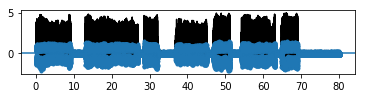

In [719]:
#flydir = '/home/alysha/media/imager/FlyDataD/lysh_ephys_ata_old/'
#flydir = '/home/alysha/media/imager/FlyDataD/brad_b2_data/'

#localfile = flydir + '2018_03_05_0024.abf'
#localfile = flydir + '2018_10_29_0009.abf'
localfile = flydir + '2018_12_04_0006.abf'
 
r =AxonIO(localfile)
 
bl = r.read_block(lazy=False, cascade=True)
 
hutch = np.asarray(bl.segments[0].analogsignals[5])
 
fs_axon = 1.0/20000.0
 
times=np.linspace(0,len(hutch)/(1/fs_axon),len(hutch))
 
# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)
 
ax1 = plt.subplot(311)
 
ax1.plot(times,hutch_det,'k')
 
#identify all relative minima
from scipy.signal import argrelmin
inds = argrelmin(hutch_det, order = 5)
ax1.plot(times[inds], hutch_det[inds], '.')
ax1.axhline(-0.08)
inds = np.array(inds)
inds = np.transpose(inds)
 

In [720]:
 
## identify the ventral flip of each wingbeat by applying a threshold
thresh = -.01 #adjust as needed
flipInds = []
flipInds = np.argwhere(hutch_det[inds]>thresh)
flipInds = inds[flipInds]
flipInds = flipInds[:,0]
 
#% now find the phase of the ventral flip 
 
#filter hütchen signal to make it more sinusoidal
 
from scipy import signal
from scipy.signal import butter, lfilter, freqz
 
def butter_lowpass(highcut, fs, order=4):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 

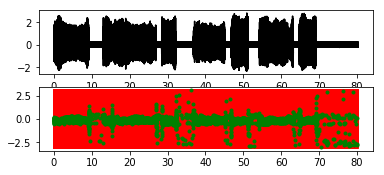

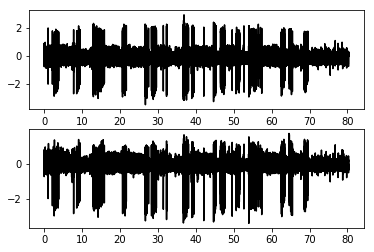

In [721]:
 
# Filter requirements.
order = 4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 300.0  # desired cutoff frequency of the filter, Hz
 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(highcut, fs, order)
 
 
hutch_filt = signal.filtfilt(b, a, hutch_det)
 
ax2 = plt.subplot(312, sharex=ax1)
 
ax2.plot(times,hutch_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
hutch_analytic = hilbert(hutch_filt)
inst_phase = np.angle(hutch_analytic)
 
 
ax3 = plt.subplot(313, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,hutch_analytic,'k')
ax3.plot(times,inst_phase,'r')
ax3.plot(times[flipInds],inst_phase[flipInds],'g.')


#%% detect muscle spikes and sort them
 
musc = np.asarray(bl.segments[0].analogsignals[0])
 
plt.figure(2)
ax1 = plt.subplot(211)
ax1.plot(times,musc,'k')
 
#apply median filter and detrend muscle signal
 
musc_det = musc-signal.medfilt(musc,35)
 
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times,musc_det,'k')
 
# threshold the detrended signal (convert the spikes into binary)
# calculate the change in, identify the spike starts/stops 
#thresh = 4
thresh =  0.6 #1.1
deltas = np.diff(np.array(-1*musc_det>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]

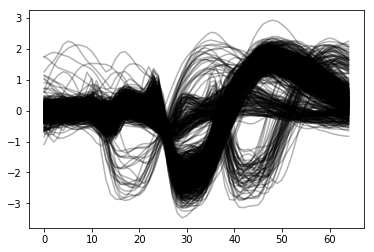

In [722]:
  
#find the peak changes in the thresholded signal, and find the associated waveform   
intervals = np.hstack((starts,stops))
spiketimes = [np.argmax(musc[sta:stp])+sta for sta,stp in intervals][2:-2]
waveforms = [musc[pk-25:pk+40] for pk in spiketimes]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(waveforms)):
    plt.plot(waveforms[i], 'k', alpha = 0.3)
 
wv_mtrx = np.vstack([np.array(wv) for wv in waveforms])

 
#%% extract the features of the waveforms to cluster the data
 
cov_wav = np.cov(wv_mtrx.T)
eig_vals, eig_vecs = np.linalg.eig(cov_wav)
#for ev in eig_vecs:
    #np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

[[-0.77448788 -0.96399058]
 [ 8.0786993  -1.60448364]]


' \ntest3 = np.argwhere(labels=0)\n\nfor i in range(len(test3)):\n   plt.plot(wv_mtrx[test3[i]])\n'

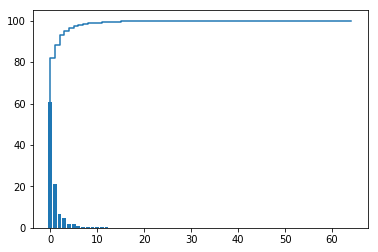

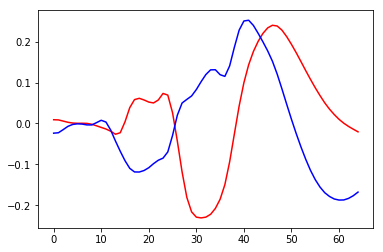

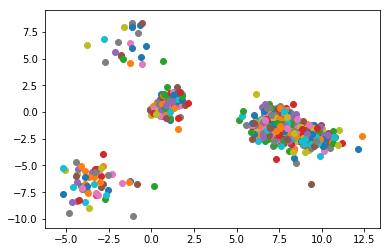

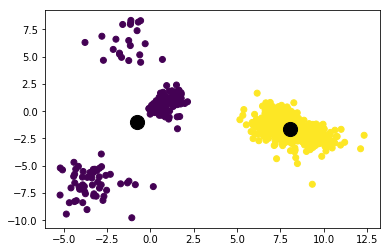

In [724]:
 
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
 
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
 
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
 
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
 
plt.figure(4)
plt.bar(range(65), var_exp)
plt.step(range(65), cum_var_exp)
 
#contruct the projection matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(65,1),
                      eig_pairs[1][1].reshape(65,1)))
 
plt.figure(5)
plt.plot(matrix_w[:,0],'r')
plt.plot(matrix_w[:,1],'b')
 
plt.figure(6)
proj = []
proj1 = []
proj2 =[]
for i in range(len(wv_mtrx)):
    musc_proj = np.dot(wv_mtrx[i], matrix_w)
    proj.append(musc_proj[0])
    proj1.append(musc_proj[1])
    proj2.append(musc_proj)
    plt.scatter(musc_proj[0], musc_proj[1])
 
     
X = np.array(list(zip(proj, proj1)))
 
#%%
from sklearn.cluster import KMeans
 
# Number of clusters
#kmeans = KMeans(n_clusters=2)
#n_clusters=1
n_clusters=2
kmeans = KMeans(n_clusters=2)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
 
#print(C) 
print(centroids)
 
plt.figure(7)
plt.scatter(X[:, 0], X[:, 1], c=labels)
 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200);
 
""" 
test3 = np.argwhere(labels=0)
 
for i in range(len(test3)):
    plt.plot(wv_mtrx[test3[i]])
"""

In [725]:
    
#%%


###### categorize and plot the labels 

labeled_spikes= zip(spiketimes,labels)

In [726]:
def cutoff(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

#Type_a_spikes = cutoff(0.5, labeled_spikes)
Type_a_spikes = cutoff(0.5, labeled_spikes)

In [727]:
def cutoff_2(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_b_spikes = cutoff_2(0.5, labeled_spikes)

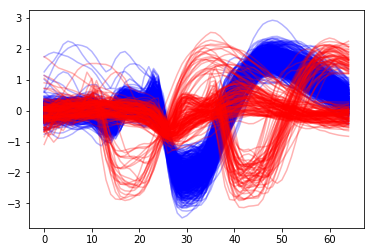

In [728]:
#print(zip_hutch)
#
x_val = [x[0] for x in Type_a_spikes]
y_val = [x[1] for x in Type_a_spikes]

#Type_b_spikes = Type_a_spikes

x_val_b = [x[0] for x in Type_b_spikes]
y_val_b = [x[1] for x in Type_b_spikes]



labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(labeled_waveforms_type_a)):
    plt.plot(labeled_waveforms_type_a[i], 'b', alpha = 0.3)

plt.figure(3)
for i in range(len(labeled_waveforms_type_b)):
    plt.plot(labeled_waveforms_type_b[i], 'r', alpha = 0.3)

#%%
### delete this freq shit
###Use Hilbert function againt o calculate the instantaneous freq. of B2

plt.figure(12)

# Filter requirements.
order = 10  #4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 200.0  # desired cutoff frequency of the filter, Hz

In [730]:
x_val_b= x_val

Brad, the chrimson signal was moved to channel 12 for your recordings/the more recent ones!

Use the commented out bit below:
#crimson = np.asarray(bl.segments[0].analogsignals[12])

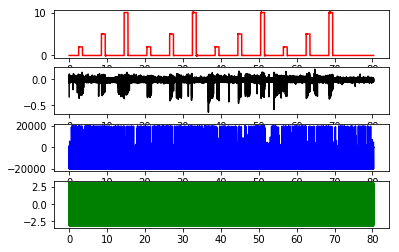

In [731]:
crimson = np.asarray(bl.segments[0].analogsignals[12])
#crimson = np.asarray(bl.segments[0].analogsignals[7])

def butter_lowpass_1(highcut, fs, order=10):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 
 

 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass_1(highcut, fs, order)
 
 
muscb2_filt = signal.filtfilt(b, a, musc_det)

ax1 = plt.subplot(411)
ax1.plot(times, crimson, 'r')
 
ax2 = plt.subplot(412, sharex=ax1)
 
ax2.plot(times,muscb2_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
musc_analytic = hilbert(muscb2_filt)
inst_phase = np.angle(musc_analytic)

#instantaneous_phase = np.unwrap(np.angle(musc_analytic))
instantaneous_frequency = (np.diff(inst_phase) /(2.0*np.pi) * fs)
 
ax3 = plt.subplot(413, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,musc_analytic,'k')
#ax3.plot(times,inst_phase,'r')

times_freq = np.delete(times, 1540096)

ax3.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(times, inst_phase, 'g')

In [66]:
#ax1 = plt.subplot(611)

#ax1.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

IndexError: list index out of range

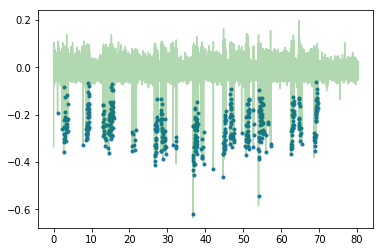

In [732]:
#%%



### delete this freq shit also 
import numpy as np
#data = musc[x_val]
data = musc[x_val_b]
#data = muscb2_filt
import seaborn as sns
data1 = muscb2_filt[x_val_b]
#data1 = muscb2_filt[x_val]
from scipy.signal import savgol_filter

#detect B2 spikes-- Use negative values

#times_between_spikes =  

plt.figure(13)

labeled_b2_spikes= zip(times[x_val_b], muscb2_filt[x_val_b])
ax1 = plt.subplot(111)
#inds_b2 = argrelmin(muscb2_filt[x_val_b], order = 5)
#ax1.plot(times[inds_b2], muscb2_filt[inds_b2], '.')
ax1.plot(times[x_val_b], muscb2_filt[x_val_b], '.')
ax1.plot(times, muscb2_filt, 'g', alpha = 0.3)

def cutoff_3(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Detected_spikes = cutoff_3(0.2, labeled_b2_spikes)

times_k= []
periods = []

for i in range(len(times)):
    for t in range(len(x_val_b)):
        #z = times[x_val_b[t-2]]
        a = times[x_val_b[t]]
        b = times[x_val_b[t-1]]
        c = times[x_val_b[t+1]]
        #d = times[x_val_b[t+2]]
        if t<= 2:
            periods.append(100)
        else:
            times_k.append(times[x_val_b[t]])
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
            #if 
              #  periods.append(a-b)


In [18]:
'''
times_k= []
periods = []



for i in range(len(times)):
    for t in range(len(x_val_b)):
        #z = times[x_val_b[t-2]]
        a = times[x_val_b[t]]
        b = times[x_val_b[t-1]]
        c = times[x_val_b[t+1]]
        #d = times[x_val_b[t+2]]
        if t<= 2:
            periods.append(100)
        else:
            times_k.append(times[x_val_b[t]])
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
            #if 
              #  periods.append(a-b)
'''

'\ntimes_k= []\nperiods = []\n\n\n\nfor i in range(len(times)):\n    for t in range(len(x_val_b)):\n        #z = times[x_val_b[t-2]]\n        a = times[x_val_b[t]]\n        b = times[x_val_b[t-1]]\n        c = times[x_val_b[t+1]]\n        #d = times[x_val_b[t+2]]\n        if t<= 2:\n            periods.append(100)\n        else:\n            times_k.append(times[x_val_b[t]])\n            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4\n            periods.append(avg)\n            #if \n              #  periods.append(a-b)\n'

In [733]:
spike_window = 3
window = 10

times_p =[]
periods =[]

avg = 100

for i in range(len(times)):
    if i in x_val_b[1:]:
        c = x_val_b.index(i)
        a = times[x_val_b[c]]
        b = times[x_val_b[c-1]]
        #c = times[x_val_b[i+1]]
        #d = times[x_val_b[t+2]]
        if c<= 1:
            periods.append(100)
        else:
            times_p.append(times[x_val_b[c]])
            #print ('spike')
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
    else:
        periods.append(avg)
        


In [734]:
print(len(periods))
print(len(times))


1605632
1605632


In [735]:
b2_frequencies = [1/period for period in periods]
len (b2_frequencies)

1605632

In [484]:
from scipy import signal

In [485]:
x = np.linspace(0, 10, 20, endpoint=False)
y = np.cos(-x**2/6.0)
f = signal.resample(y, 100)
xnew = np.linspace(0, 10, 100, endpoint=False)

ValueError: x and y must have same first dimension, but have shapes (1720320,) and (20,)

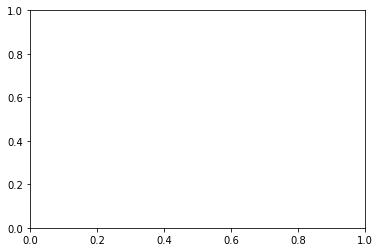

In [487]:
import matplotlib.pyplot as plt
plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [486]:
x= times
y2  = b2_frequencies

f = signal.resample(y2, 180000000)
xnew = np.linspace(0, times[len(y2)-1], 180000000, endpoint=False)

In [295]:
import matplotlib.pyplot as plt
plt.plot(x, y2, 'go-', xnew, f, '.-', 10, y2[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

KeyboardInterrupt: 

In [695]:
import pandas as pd

In [736]:
power_muscle_frequencies_df = pd.DataFrame((b2_frequencies))
power_muscle_frequencies_df.to_csv('power_muscle_11_frequencies_df.csv', index=False)

periods_df = pd.DataFrame((periods))
periods_df.to_csv('power_muscle_11_periods_df.csv', index=False)



In [737]:
chrimson_df = pd.DataFrame((crimson))
chrimson_df.to_csv('chrimson_11_df.csv', index=False)

In [738]:
times_df = pd.DataFrame(times)
times_df.to_csv('times_11_df.csv', index=False)

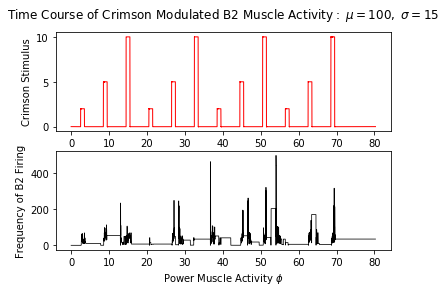

In [739]:

plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
#ax2.set_ylim(-5, 20)
#savitzky_golay
freq_hat = savgol_filter(b2_frequencies, 75, 11) # window size 51, polynomial order 3

#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)

#ax2.plot(times, freq_hat[:-3],'k', linewidth = 0.75)
ax2.plot(times, b2_frequencies,'k', linewidth = 0.75)

#peristimulus time historgram

#and then compute the Fourier transform as


#plt.title(r'$\mathrm{Histogram\ of\ B2 Muscle Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')

ax1.set_ylabel('Crimson Stimulus', size=10)
ax1.set_title(r'$\mathrm{Time\ Course\ of\ Crimson\ Modulated\ B2\ Muscle\ Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of B2 Firing', size=10)
plt.xlabel('Power Muscle Activity $\phi$', size=10)

import numpy.fft as fft
spectrum = fft.fft(data1)
#You can then plot the magnitudes of the FFT as

The last few cells are probably the ones you're after.  So here you can see (vs the other notebook I sent you) the limitations of the direct data period/freq analysis.  This will be ameliorated a bit by increasing the sample size.  However, the other approach I tried before (that I can also try and recreate) was running these raw traces through filters to try get slightly smoother.

In [740]:
f1 = pd.read_csv('power_muscle_11_frequencies_df.csv')
f2 = pd.read_csv('power_muscle_11_periods_df.csv')
f3 = pd.read_csv('chrimson_11_df.csv')
f4 = pd.read_csv('times_11_df.csv')


In [741]:
df = pd.DataFrame()

# Add a new columns with impoact force in units of Newtons
df['b2 frequencies'] = f1
df['b2 periods'] = f2
df['chrimson stimulus'] = f3
df['times'] = f4

# Take a look
df.head()

,b2 frequencies,b2 periods,chrimson stimulus,times
0,0,100,0.009155,0.00000
1,0,100,0.009155,0.00005
2,0,100,0.009155,0.00010
3,0,100,0.009155,0.00015
4,0,100,0.009155,0.00020


In [742]:
max_chrimson_stim = df['chrimson stimulus'] >= 9.9
#max_chrimson_stim.head()

max_inds = df.loc[max_chrimson_stim]
max_inds.head()

,b2 frequencies,b2 periods,chrimson stimulus,times
289930,4.622137,0.21635,9.995728,14.496509
289931,4.622137,0.21635,9.995728,14.496559
289932,4.622137,0.21635,9.996033,14.496609
289933,4.622137,0.21635,9.996338,14.496659
289934,4.622137,0.21635,9.996338,14.496709


In [58]:
#for ind in range(len(max_inds)-1):
#    if times[ind]-times[ind -1] >= 1:
#        chrimson_on = 

SyntaxError: invalid syntax (<ipython-input-58-9ed1209a9b95>, line 3)

In [743]:
crimson_on = []
crimson_off = []

for f in range(len(f3)-1):
    if crimson[f]-crimson[f-1]>= 1.05:  #1.55
        crimson_on.append(f)
    if crimson[f]-crimson[f+1] >= 1.05:  #<= - 0.75:
        crimson_off.append(f)

In [744]:
for i in range(len(crimson_on)-1): 
    if crimson_on[i] - crimson_on[i+1] >= - 100:
        del crimson_on[i+1]

for i in range(len(crimson_off)-1): 
    if crimson_off[i] - crimson_off[i+1] >= - 100:
        del crimson_off[i+1]        

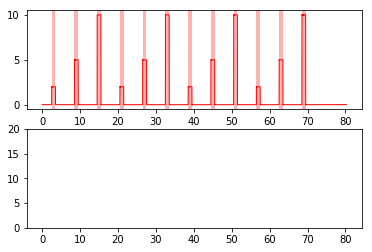

In [745]:
fig =plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(0, 20)
#ax2.set_xlim(20, 80)
#savitzky_golay
'''freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'''
#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)
        
for i in range(len(crimson_on)):
    ax1.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)
    #ax2.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)

In [746]:
print(len(crimson_on), (crimson_on)) 
print(len(crimson_off), (crimson_off))

(12, [49938, 169925, 289930, 409989, 529989, 649989, 769988, 889982, 1009987, 1129985, 1249983, 1369981])
(12, [69928, 189923, 309989, 429987, 549983, 669986, 789987, 909981, 1029984, 1149985, 1269983, 1389983])


In [83]:
'''
df_freq_upon_signal = pd.DataFrame()

for i in range(len(crimson_on)):
    on_signal = crimson_on[i]
    f = b2_frequencies[on_signal-5000: on_signal+10000]
    
    f2 = signal.resample(y2, )
    xnew = np.linspace(0, times[len(y2)-1], 180000000, endpoint=False)
    
    
    
    df_freq_upon_signal[i]=f
'''

**** switch here to make the fixed time on the chrimson time scale and then
upsample in the lower frequency area

In [ ]:
#***duplicate older version

#df_freq_upon_signal = pd.DataFrame()

#for i in range(len(crimson_on)):
#    on_signal = crimson_on[i]
#    off_signal = crimson_off[i]
#    f = b2_frequencies[on_signal-5000: off_signal+1000]
#    df_freq_upon_signal[i]=f

In [747]:
crimson_off[0] + 1000 - crimson_on[0] + 2500 

23490

In [709]:
#df_freq_upon_signal_2 = pd.DataFrame()
df_freq_upon_signal_3 = pd.DataFrame()

for i in range(len(crimson_on)-1):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
    if i != 0:
        if i !=len(crimson_on): 
            next_off_signal = crimson_off[i+1]
            next_on_signal = crimson_on[i+1]
            prior_off_signal = crimson_off[i-1]
            alt_f = b2_frequencies[prior_off_signal: next_on_signal]
        
            f3 = signal.resample(alt_f, 1000000)
            xnew3 = np.linspace(prior_off_signal, next_on_signal, 1000000, endpoint=False)
            df_freq_upon_signal_3[i]=f3
        
        
    #f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    #f2 = signal.resample(f, 500000)
    #xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    #x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    #df_freq_upon_signal_2[i]=f2

d={}
for x in range(1,10):
        d["crimson{0}".format(i)]="Hello"

In [ ]:
CHANGE FLY NUM

In [748]:
#df_freq_upon_signal_2 = pd.DataFrame()
df_freq_upon_signal_4 = pd.DataFrame()
d={} 

for i in range(len(crimson_on)-1):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
    if i != 0:
        if i !=len(crimson_on): 
            next_off_signal = crimson_off[i+1]
            next_on_signal = crimson_on[i+1]
            prior_off_signal = crimson_off[i-1]
            alt_f = b2_frequencies[prior_off_signal: next_on_signal]
        
            f3 = signal.resample(alt_f, 1000000)
            xnew3 = np.linspace(prior_off_signal, next_on_signal, 1000000, endpoint=False)
            df_freq_upon_signal_4[i]=f3
            resampled_crim = signal.resample(crimson[prior_off_signal: next_on_signal],1000000)
            resampled_times = signal.resample(times[prior_off_signal: next_on_signal],1000000)
            d["fly05_b2_df{0}".format(i)]=f3
            d["fly05_crimson{0}".format(i)]=resampled_crim
            d["fly05_times{0}".format(i)]= resampled_times
        
    #f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    #f2 = signal.resample(f, 500000)
    #xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    #x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    #df_freq_upon_signal_2[i]=f2

In [749]:
d

{'fly05_b2_df1': array([68.72847953, 75.86293471, 77.77227922, ..., 24.88402971,
        41.13312595, 56.61064566]),
 'fly05_b2_df10': array([5.63856429, 5.80134643, 5.84492588, ..., 4.63840172, 5.00904411,
        5.36211237]),
 'fly05_b2_df2': array([54.20050825, 59.45306921, 60.85502467, ..., 21.87571235,
        33.86071007, 45.2716084 ]),
 'fly05_b2_df3': array([40.81630111, 44.57773313, 45.58143846, ..., 17.6489082 ,
        26.24227011, 34.41997461]),
 'fly05_b2_df4': array([ 6.54449854,  3.43142888,  2.59907376, ..., 25.6892247 ,
        18.5921261 , 11.83400824]),
 'fly05_b2_df5': array([49.14001854, 48.83748486, 48.75925394, ..., 51.04683246,
        50.33341647, 49.66084562]),
 'fly05_b2_df6': array([34.54229282, 38.33543304, 39.34867076, ..., 11.19732572,
        19.85411258, 28.09468124]),
 'fly05_b2_df7': array([4.89475956, 5.37877303, 5.50724101, ..., 1.90164606, 3.01355906,
        4.06993889]),
 'fly05_b2_df8': array([53.05036484, 58.74861   , 60.27421182, ..., 18.0438

In [750]:
resampled_df = pd.DataFrame(d)
resampled_df.head()

,fly05_b2_df1,fly05_b2_df10,fly05_b2_df2,fly05_b2_df3,fly05_b2_df4,fly05_b2_df5,fly05_b2_df6,fly05_b2_df7,fly05_b2_df8,fly05_b2_df9,...,fly05_times1,fly05_times10,fly05_times2,fly05_times3,fly05_times4,fly05_times5,fly05_times6,fly05_times7,fly05_times8,fly05_times9
0,68.728480,5.638564,54.200508,40.816301,6.544499,49.140019,34.542293,4.894760,53.050365,46.511599,...,3.496402,57.499286,9.496156,15.499460,21.499363,27.499167,33.499321,39.499375,45.499078,51.499232
1,75.862935,5.801346,59.453069,44.577733,3.431429,48.837485,38.335433,5.378773,58.748610,51.051778,...,2.274179,56.277116,8.273356,14.277254,20.277140,26.276917,32.277152,38.277169,44.276837,50.277036
2,77.772279,5.844926,60.855025,45.581438,2.599074,48.759254,39.348671,5.507241,60.274212,52.264546,...,1.947632,55.950554,7.946979,13.950703,19.950594,25.950378,31.950589,37.950618,43.950296,49.950481
3,75.559446,5.794448,59.222775,44.413263,3.565036,48.854531,38.171265,5.356561,58.507119,50.855198,...,2.327018,56.329882,8.326978,14.330069,20.329979,26.329793,32.329917,38.329984,44.329701,50.329838
4,71.211409,5.695238,56.022193,42.122954,5.461739,49.037035,35.861004,5.062320,55.033874,48.089876,...,3.071539,57.074347,9.072099,15.074571,21.074500,27.074341,33.074382,39.074486,45.074240,51.074331


In [751]:
from scipy import stats

In [752]:
fly_05_b2_mean_freq_change = df_freq_upon_signal_4.mean(axis=1)
fly_05_b2_freq_error = stats.sem(df_freq_upon_signal_4,axis = 1)

In [753]:
#fly_01_b2_mean_freq_change.iloc[0]
fly_05_b2_mean_freq_change_series = fly_05_b2_mean_freq_change.T
#type(_)
type(fly_05_b2_mean_freq_change_series)

pandas.core.series.Series

In [597]:
#fly_01_b2_mean_freq_change_series

In [754]:
type(fly_05_b2_mean_freq_change)
type(fly_05_b2_freq_error)
#fly_01_b2_freq_error
#fly_01_b2_freq_error = pd.Series(fly_01_b2_freq_error)
#shape(fly_01_b2_freq_error)
#fly_01_b2_mean_freq_change = df.values(fly_01_b2_mean_freq_change)

numpy.ndarray

In [570]:
#fly_01_b2_mean_freq_change.head()
#fly_01_b2_freq_error = pd.DataFrame(fly_01_b2_freq_error)

In [755]:
d["fly_05_b2_mean_freq_change_series"]=fly_05_b2_mean_freq_change_series
d["fly_05_b2_freq_error"]=fly_05_b2_freq_error

In [756]:
resampled_df = pd.DataFrame(d)
resampled_df.head()

,fly05_b2_df1,fly05_b2_df10,fly05_b2_df2,fly05_b2_df3,fly05_b2_df4,fly05_b2_df5,fly05_b2_df6,fly05_b2_df7,fly05_b2_df8,fly05_b2_df9,...,fly05_times2,fly05_times3,fly05_times4,fly05_times5,fly05_times6,fly05_times7,fly05_times8,fly05_times9,fly_05_b2_freq_error,fly_05_b2_mean_freq_change_series
0,68.728480,5.638564,54.200508,40.816301,6.544499,49.140019,34.542293,4.894760,53.050365,46.511599,...,9.496156,15.499460,21.499363,27.499167,33.499321,39.499375,45.499078,51.499232,7.270127,36.406739
1,75.862935,5.801346,59.453069,44.577733,3.431429,48.837485,38.335433,5.378773,58.748610,51.051778,...,8.273356,14.277254,20.277140,26.276917,32.277152,38.277169,44.276837,50.277036,8.122827,39.147859
2,77.772279,5.844926,60.855025,45.581438,2.599074,48.759254,39.348671,5.507241,60.274212,52.264546,...,7.946979,13.950703,19.950594,25.950378,31.950589,37.950618,43.950296,49.950481,8.357596,39.880667
3,75.559446,5.794448,59.222775,44.413263,3.565036,48.854531,38.171265,5.356561,58.507119,50.855198,...,8.326978,14.330069,20.329979,26.329793,32.329917,38.329984,44.329701,50.329838,8.085547,39.029964
4,71.211409,5.695238,56.022193,42.122954,5.461739,49.037035,35.861004,5.062320,55.033874,48.089876,...,9.072099,15.074571,21.074500,27.074341,33.074382,39.074486,45.074240,51.074331,7.561800,37.359764


In [757]:
resampled_df.to_csv('/home/alysha/analysis_files/S81/s81_b2_df_fly_05.csv', index=False)



In [364]:
df_freq_upon_signal_2 = pd.DataFrame()


for i in range(len(crimson_on)):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
         
        
    f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    f2 = signal.resample(f, 500000)
    xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    df_freq_upon_signal_2[i]=f2

In [310]:
x = np.arange(on_signal, off_signal)
xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)

import matplotlib.pyplot as plt
plt.plot(x, f, 'go-', xnew, f2, '.-', on_signal, f[12], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

TypeError: 'int' object has no attribute '__getitem__'

ValueError: x and y must have same first dimension, but have shapes (23497,) and (23500,)

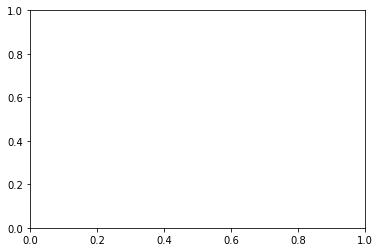

In [268]:
x = np.arange(on_signal, off_signal)
xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)

import matplotlib.pyplot as plt
plt.plot(x, f, 'go-', xnew, f2, '.-', off_signal, f[12], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

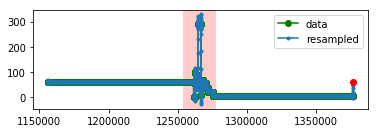

In [459]:
fig =plt.figure(18)

x = np.arange(prior_off_signal, next_on_signal)
xnew = np.linspace(prior_off_signal, next_on_signal, 1000000, endpoint=False)

ax2 = fig.add_subplot(212)

import matplotlib.pyplot as plt
plt.plot(x, alt_f, 'go-', xnew, f3, '.-', next_on_signal, alt_f[11], 'ro')
ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
#ax2.axvspan(prior_on_signal, prior_off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [460]:
df_freq_upon_signal_3.head()

,1,2,3,4,5,6,7,8,9,10
0,74.349397,84.033562,24.301322,43.668096,40.160618,122.699312,48.661771,34.013585,33.670013,59.171562
1,81.060364,87.507087,25.281518,48.105317,40.856133,130.765622,48.962106,31.215378,30.834294,65.191815
2,82.848692,88.439379,25.544535,49.291808,41.050647,132.921733,49.039688,30.466977,30.077110,66.798369
3,80.763229,87.363459,25.240898,47.915111,40.839322,130.418663,48.945065,31.335127,30.958282,64.927111
4,76.678682,85.244716,24.643078,45.211737,40.409689,125.504807,48.763953,33.040170,32.686624,61.258447


In [461]:
df_freq_upon_signal_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,6.861059,606.060229,15.698577,2.477392,0.377408,27.586190,11.750874,1.428061,1.561767,34.364240,19.047607,1.873886
1,4.960025,623.033340,15.150813,2.160898,0.281890,27.372737,11.847829,-0.137589,0.236583,35.236271,14.378886,0.426441
2,3.291062,637.934718,14.692535,1.882598,0.197072,27.185386,11.932925,-1.509908,-0.928699,36.000696,10.280409,-0.765233
3,1.858877,650.722116,14.320880,1.643362,0.123371,27.024658,12.005926,-2.685415,-1.930435,36.655560,6.763737,-1.717363
4,0.665168,661.380197,14.031969,1.443562,0.061060,26.890737,12.066749,-3.663127,-2.767071,37.200299,3.833023,-2.447238


In [62]:
outliers =[]


'''
for i in df_freq_upon_signal:
    #on_signal = crimson_on[i]
    for j in range(len(df_freq_upon_signal[i])):
        if df_freq_upon_signal[i][j]>= 150:
            outliers.append(i)
'''

In [67]:
#print(outliers)

#new_df = df_freq_upon_signal.drop(17, axis=1)#.head()

In [462]:
#new_df = df_freq_upon_signal_2
new_df = df_freq_upon_signal_3

In [ ]:
#fig =plt.figure(18)

#x = np.arange(prior_off_signal, next_on_signal)
#xnew = np.linspace(prior_off_signal, next_on_signal, 1000000, endpoint=False)

#ax2 = fig.add_subplot(212)

#import matplotlib.pyplot as plt
#plt.plot(x, alt_f, 'go-', xnew, f3, '.-', next_on_signal, alt_f[11], 'ro')
#ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
##ax2.axvspan(prior_on_signal, prior_off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
#plt.legend(['data', 'resampled'], loc='best')
#plt.show()

'freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'

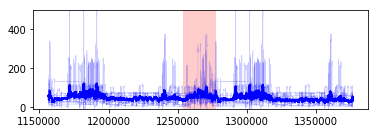

In [463]:
fig =plt.figure(15)

ax1 = plt.subplot(211)

for i in new_df:
    ax1.plot(xnew, new_df[i], 'b', linewidth =0.5, alpha = 0.2)
    
    
ax1.set_ylim((-10,500))
#ax1.set_ylimit(-0.1, 100)
#ax1.set_xlim((1200000,1300000))


mean_freq_change = new_df.mean(axis=1)
ax1.plot(xnew, mean_freq_change, 'b', linewidth =2.0)

ax1.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)

'''
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(0, 20)
#ax2.set_xlim(20, 80)
#savitzky_golay
'''
'''freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'''
#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)
        
#for i in range(len(crimson_on)):
#    ax1.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)
#    #ax2.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)

In [464]:
from scipy import stats

In [465]:
mean_freq_change = new_df.mean(axis=1)
freq_error = stats.sem(new_df,axis = 1)

Text(0.5,0,u'Time (s)')

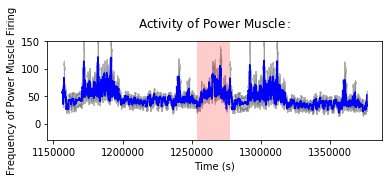

In [468]:
fig =plt.figure(16)


#wbf_means = wbf_means[0:len(wbf_means):10]
#wbf_error = stats.sem(all_wbf,axis = 0)
#wbf_error = wbf_error[0:len(wbf_error):10]

ax2 = fig.add_subplot(212)

ax2.set_ylim((-30,150))
#ax1.set_ylimit(-0.1, 100)
#ax2.set_xlim((1220000,1300000))
#ax2.set_xlim((1340000,1400000))

#ax2.axvspan(0.25, .75, facecolor = 'r', edgecolor = 'none', alpha = 0.3)
ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
ax2.plot(xnew,mean_freq_change, 'b')
ax2.fill_between(xnew,mean_freq_change+freq_error, mean_freq_change-freq_error,color='k', alpha = 0.3, edgecolor = 'none')

ax2.set_title(r'$\mathrm{Activity\ of\ Power \ Muscle:}$', size=12, horizontalalignment='center',  y=1.08)#   \ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of Power Muscle Firing', size=10)
plt.xlabel('Time (s)', size=10) # $\phi$', size=10)
#ax2.title('B2 spike frequency')

In [ ]:
### Then plot this over time
### Update on git -- new analysis file for each genotype
### Develop a pattern of dataframe organization
### blue card 
### bills
### analysis
### tutor
### cv website
### laudry 


In [469]:
#altair and bokeh plotting

new_df.to_csv('s81_b2_06_df.csv', index=False)